   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   
5     0   43        2.0              0         0.0     0.0                0   
6     0   63        1.0              0         0.0     0.0                0   
7     0   45        2.0              1        20.0     0.0                0   
8     1   52        1.0              0         0.0     0.0                0   
9     1   43        1.0              1        30.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  2

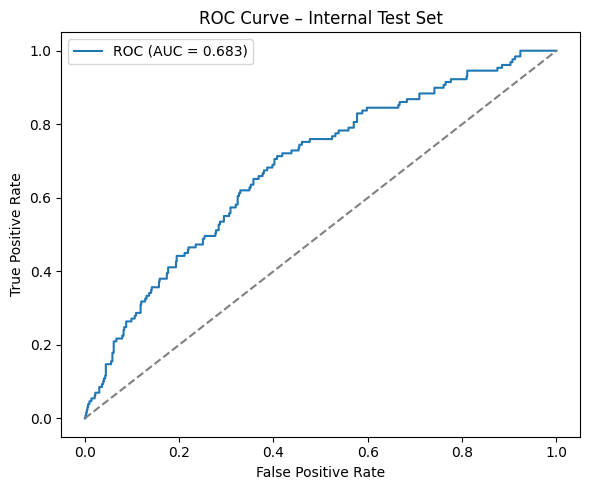

  Sex   Age  Weight (kg)  Height (m)   BMI  Abdominal Circumference (cm)  \
0   F  32.0         69.1        1.71  23.6                          86.2   
1   F  55.0        118.7        1.69  41.6                          82.5   
2   M   NaN          NaN        1.83  26.9                         106.7   
3   M  44.0        108.3        1.80  33.4                          96.6   
4   F  32.0         99.5        1.86  28.8                         102.7   
5   F  58.0        117.9        1.87  33.7                          81.4   
6   M  33.0        117.9        1.82  35.6                          74.8   
7   M  55.0        100.1        1.74  33.1                          96.6   
8   F  37.0        110.1        1.86  31.8                          92.4   
9   F  58.0         97.6        1.86  28.2                          74.6   

  Blood Pressure (mmHg)  Total Cholesterol (mg/dL)  HDL (mg/dL)  \
0                125/79                      248.0         78.0   
1                139/70      

In [ ]:
## Matthew Lambalot 

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

## Load dataset 

## data taken from framingham heart study that includes ~8500 patients and is used to predict whether a patient has a 10-year risk of future coronary heart disease

CHD_df= pd.read_csv("framingham.csv")

print(CHD_df.head(10))

## inlude inputs that people will have available readily

input= ["age", "male", "currentSmoker", "diabetes", "BMI"]

output= "TenYearCHD"

X= CHD_df[input]
Y= CHD_df[output]

#print(X.head(5))
#print(Y.head(5))

## split into training and testing dataset 

X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=.2, random_state=42, stratify=Y)


## Preprocess to split inputs into analog and binary values 

binary_inputs= ["male", "currentSmoker", "diabetes"]
num_inputs= ["age", "BMI"]

num_pipe= Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())])

pre_pros= ColumnTransformer(transformers=[("numeric", num_pipe, num_inputs), ("binary", "passthrough", binary_inputs)])



## Model creation: simple logistic regression model 

model= Pipeline(steps=[("preprocess", pre_pros), ("classifier", LogisticRegression(max_iter=1000, solver="lbfgs"))])

model.fit(X_train, y_train)




## Evaluate model

CHD_prob= model.predict_proba(X_test)[:,1]

## Calculate AUC score and plot roc curve 

auc= roc_auc_score(y_test, CHD_prob)
print(f"Test AUC: {auc:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, CHD_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Internal Test Set")
plt.legend()
plt.tight_layout()
plt.show()

## Save model for sqlite app 

joblib.dump(model, "cvd_logistic_model.pkl")

### Testing model on external dataset for validation 

ext_df= pd.read_csv("CVD_2025_Data.csv")
print(ext_df.head(10))

## Match the inputs of the 2025 Data to the framingham study variable names
ext_df_model = pd.DataFrame({
    "age": ext_df["Age"],
    "male": (ext_df["Sex"] == "M").astype(int),
    "currentSmoker": (ext_df["Smoking Status"] == "Smoker").astype(int),
    "diabetes": (ext_df["Diabetes Status"] == "Yes").astype(int),
    "BMI": ext_df["BMI"]})

## This data set is not longitudinal, it just estimates the risk as low, med, high. To properly test the model I am assigning anything as high risk to be considered a case 
y_ext=(ext_df["CVD Risk Level"] == "HIGH").astype(int)

## Ensure that only valud inputs are passed into the model 

valid_rows= ext_df_model.notnull().all(axis=1)
X_ext= ext_df_model.loc[valid_rows]
y_ext= y_ext.loc[valid_rows]

## Pass external dataset through the model 

y_ext_prob= model.predict_proba(X_ext)[:,1]

print("External positives:", y_ext.sum())
print("External negatives:", (y_ext == 0).sum())
print("Unique predicted risks:", np.unique(y_ext_prob)[:10])


ext_auc= roc_auc_score(y_ext, y_ext_prob)
print(f"External Validation AUC: {ext_auc:.3f}")



